# Churn Telecom

Esse projeto tem como objetivo de criar um modelo que consiga apontar com assertividade quais clientes tem probabilidade de cancelar o plano com a operadora. Além disso, a missão é compreender o que mais colabora para que o cliente cancele.

## Bibliotecas que serão utilizadas nesse projeto

In [1]:
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Imputer
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

## Sessão do Spark

In [2]:
sparkSession = SparkSession.builder.appName("churn-telco").getOrCreate()

## Leitura da base

In [3]:
# Passando esquema
schema = StructType([
        StructField("ID", IntegerType(), True),
        StructField("customerID", StringType(), True),
        StructField("gender", StringType(), True),
        StructField("SeniorCitizen", StringType(), True),
        StructField("Partner", StringType(), True),
        StructField("Dependents", StringType(), True),
        StructField("tenure", IntegerType(), True),
        StructField("PhoneService", StringType(), True),
        StructField("MultipleLines", StringType(), True),
        StructField("InternetService", StringType(), True),
        StructField("OnlineSecurity", StringType(), True),
        StructField("OnlineBackup ", StringType(), True),
        StructField("DeviceProtection", StringType(), True),
        StructField("TechSupport", StringType(), True),
        StructField("StreamingTV", StringType(), True),
        StructField("StreamingMovies ", StringType(), True),
        StructField("Contract", StringType(), True),
        StructField("PaperlessBilling", StringType(), True),
        StructField("PaymentMethod", StringType(), True),
        StructField("MonthlyCharges", DoubleType(), True),
        StructField("TotalCharges", DoubleType(), True),
        StructField("Churn", StringType(), True),
    ])

In [4]:
df = sparkSession.read.csv('../dataset/*.csv', header = True, schema = schema)

In [5]:
df.select([df.columns[i] for i in range(len(df.columns)) if i < 10]).show(truncate=False)

+----+----------+------+-------------+-------+----------+------+------------+----------------+---------------+
|ID  |customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|
+----+----------+------+-------------+-------+----------+------+------------+----------------+---------------+
|1869|7010-BRBUU|Male  |0            |Yes    |Yes       |72    |Yes         |Yes             |No             |
|4528|9688-YGXVR|Female|0            |No     |No        |44    |Yes         |No              |Fiber optic    |
|6344|9286-DOJGF|Female|1            |Yes    |No        |38    |Yes         |Yes             |Fiber optic    |
|6739|6994-KERXL|Male  |0            |No     |No        |4     |Yes         |No              |DSL            |
|432 |2181-UAESM|Male  |0            |No     |No        |2     |Yes         |No              |DSL            |
|2215|4312-GVYNH|Female|0            |Yes    |No        |70    |No          |No phone service|DSL            |
|

##  1- Análise descritiva/Exploratória dos dados

### Nesta etapa aprofundaremos um pouco nos dados que temos para entender melhor sobre o negócio que temos em mãos. Ressalto que essa é a parte mais importante de qualquer projeto de data science. Caso você não tenha em mãos dados que te contem sobre como funciona o negócio, sinto lhe dizer que o projeto não dará certo.

- Quantidade de clientes existem na base
- Proporção de clientes para quem cancela e quem fica
- Relação de clientes com o tempo de permanência com o produto (para quem pernaceu e quem saiu)
- Tipo de serviço de internet oferecido para o cliente (para quem pernaceu e quem saiu)
- Total de recargas pagas pelo cliente (para quem permaneceu e quem saiu)
- Tipo de contrato (para quem permaneceu e quem saiu)
- Serviço de telefone oferecido (para quem permaneceu e quem saiu)
- Presença de multiplas linhas de telefone (para quem permaneceu e quem saiu)

In [6]:
# Quantidade de clientes existem na base
df.select('customerID').distinct().count()

5986

In [7]:
# Summary
df.summary().toPandas()

,summary,ID,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,count,5986,5986,5986,5986,5986,5986,5986,5986,5986,...,5986,5986,5986,5986,5986,5986,5986,5986,5976,5986
1,mean,3533.5613097226865,None,None,0.16137654527230202,None,None,32.46876044102907,None,None,...,None,None,None,None,None,None,None,64.8022134981624,2298.0606174698796,None
2,stddev,2035.705665830562,None,None,0.3679086410122609,None,None,24.516390637526726,None,None,...,None,None,None,None,None,None,None,30.114701633888114,2274.1271654402035,None
3,min,0,0002-ORFBO,Female,0,No,No,0,No,No,...,No,No,No,No,Month-to-month,No,Bank transfer (automatic),18.25,18.8,No
4,25%,1777,None,None,0.0,None,None,9,None,None,...,None,None,None,None,None,None,None,35.65,404.2,None
5,50%,3546,None,None,0.0,None,None,29,None,None,...,None,None,None,None,None,None,None,70.4,1411.9,None
6,75%,5292,None,None,0.0,None,None,56,None,None,...,None,None,None,None,None,None,None,89.9,3846.75,None
7,max,7042,9993-LHIEB,Male,1,Yes,Yes,72,Yes,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Mailed check,118.75,8684.8,Yes


### Uma informação importante é que a proporção de clientes que ficam é maior do que os que cancelam. Isso é um problema muito comum quando se trata do assunto (Churn). Muitas vezes isso pode ocasionar no famoso desbalanceamento de classes. Porém, mais adianta trataremos disso.

In [8]:
# Proporção de clientes para quem cancela e quem fica
df.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 4399|
|  Yes| 1587|
+-----+-----+



### Ao analisar o tempo de fidelidade de cada cliente ao produto, percebemos que tiveram clientes que cancelaram depois de um longo tempo, mas que a maioria cancelou entre os 10-20 primeiros meses. Será que existe algum fator que esteja ocasionando nessa saída recente? 

<AxesSubplot:>

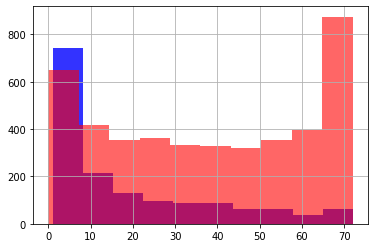

In [9]:
# Analisando o tempo de quem saiu e permaneceu na empresa
tempo = df.select('Churn','tenure').toPandas()
tempo[tempo.Churn == 'Yes']['tenure'].hist(alpha = 0.8, color = 'blue')
tempo[tempo.Churn == 'No']['tenure'].hist(alpha = 0.6, color = 'red')



### De acordo com a análise abaixo, tanto os clientes que saíram e ficaram tiveram/tem os mesmos produtos. Porém, um ponto de observação é que para aqueles que cancelaram, a Fibra optica é a mais presente. 

<AxesSubplot:xlabel='InternetService', ylabel='count'>

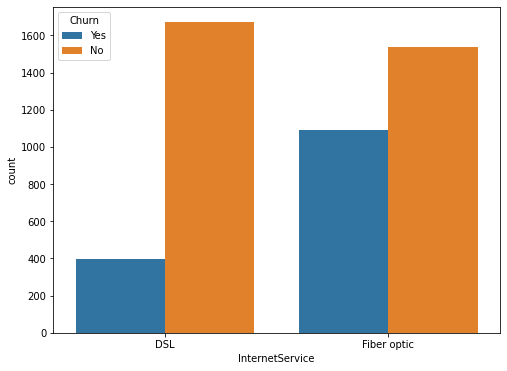

In [10]:
# Tipo de internet para clientes que saíram e permaneceram (revisar essa parte)
plt.figure(figsize=(8,6))

df_internet_service = df.filter(df.InternetService != 'No').groupBy('Churn', 'InternetService').count().orderBy(df.Churn.desc()).toPandas()

sns.barplot(
data = df_internet_service , x = 'InternetService', y= 'count', hue = 'Churn')

### Referente a total de cargas realizadas, aqui vemos que quem cancela geralmente não costuma fazer muita recarga... 

<AxesSubplot:>

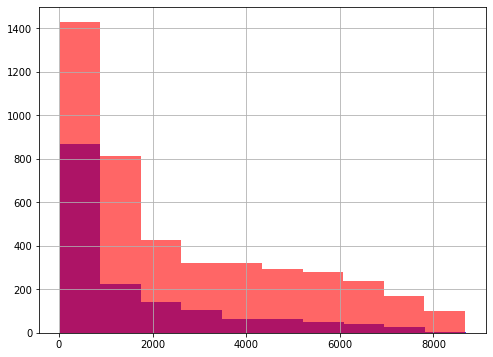

In [11]:
# Total de recargas para o cliente que permanceu e para quem cancelou
plt.figure(figsize=(8,6))
charge = df.select('Churn','TotalCharges').toPandas()
charge[charge.Churn == 'Yes']['TotalCharges'].hist(alpha = 0.8, color = 'blue')
charge[charge.Churn == 'No']['TotalCharges'].hist(alpha = 0.6, color = 'red')

### A maioria dos clientes que cancelam tem um contrato de Mês a mês. 

<AxesSubplot:xlabel='Contract', ylabel='count'>

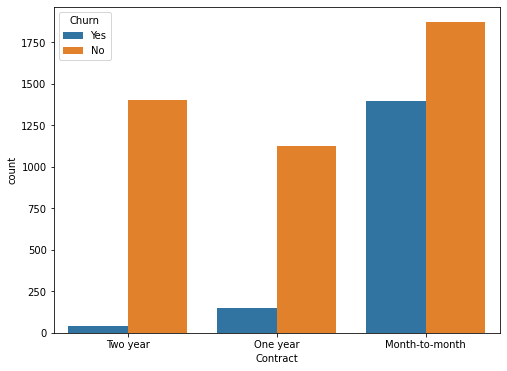

In [12]:
# Tipo de contrato para clientes que saíram e permaneceram (revisar essa parte)
plt.figure(figsize=(8,6))
df_contrato = df.groupBy('Churn', 'Contract').count().orderBy(df.Churn.desc()).toPandas()

sns.barplot(data = df_contrato, x='Contract', y='count', hue='Churn')



### Pessoas que contém serviço de celular costumam mudar de produto mais facilmente

<AxesSubplot:xlabel='PhoneService', ylabel='count'>

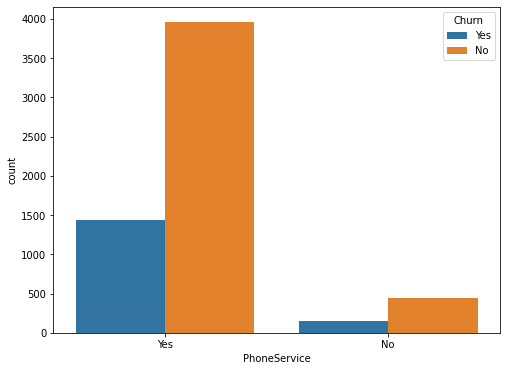

In [13]:
# Serviço de celular
plt.figure(figsize=(8,6))
df_cell_phone = df.groupBy('Churn', 'PhoneService').count().orderBy(df.Churn.desc()).toPandas()
sns.barplot(data = df_cell_phone, x = 'PhoneService', y = 'count', hue = 'Churn')

### Aqui podemos ver que o fato de ter multiplas linhas não é algo determinante para a desistência do cliente do produto em si

<AxesSubplot:xlabel='MultipleLines', ylabel='count'>

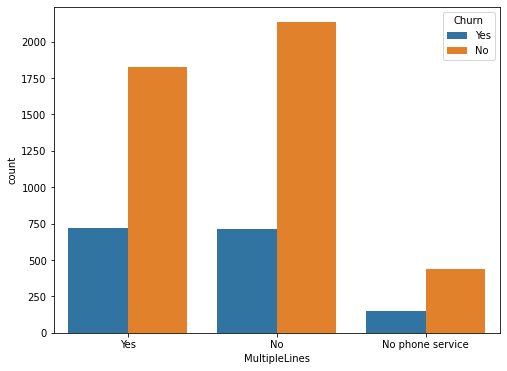

In [14]:
# Multiplas linhas de telefone
plt.figure(figsize=(8,6))

df_multiplas_linhas = df.groupBy('Churn', 'MultipleLines').count().orderBy(df.Churn.desc()).toPandas()
sns.barplot(data = df_multiplas_linhas, x='MultipleLines', y = 'count', hue = 'Churn')

### A proporção de aposentados que cancelaram ou continuaram o plano parece ser equilibrada, sendo bem diferente da proporção daqueles que não são aposentados

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

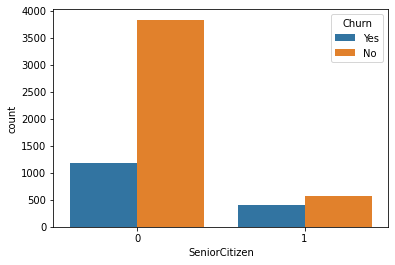

In [15]:
# Aposentados
df_aposentados = df.groupBy('Churn', 'SeniorCitizen').count().orderBy(df.Churn.desc()).toPandas()
sns.barplot(data = df_aposentados, x='SeniorCitizen', y = 'count', hue = 'Churn')

### a- A taxa de cancelamento daqueles que são aposentados e não tem parceiros é maior do que os que tem parceiros
### b- Os não aposentados que contém parceiros ou não, contém uma taxa bem menor de cancelamento

Text(0.5, 1.0, 'Partner Status')

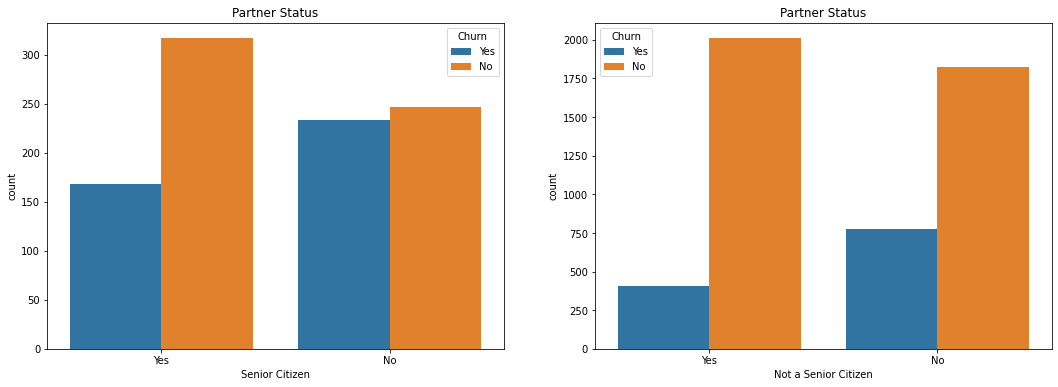

In [16]:
# Drill Down para melhor averiguar aposentados
df_aposentado = df.filter(df.SeniorCitizen == 1).groupBy('Churn', 'Partner').count().orderBy(df.Churn.desc()).toPandas()
df_nao_aposentado = df.filter(df.SeniorCitizen == 0).groupBy('Churn', 'Partner').count().orderBy(df.Churn.desc()).toPandas()
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.barplot(data = df_aposentado, x = 'Partner', y = 'count', hue = 'Churn')
plt.xlabel('Senior Citizen')
plt.title('Partner Status')
plt.subplot(1,2,2)
sns.barplot(data = df_nao_aposentado, x = 'Partner', y = 'count', hue = 'Churn')
plt.xlabel('Not a Senior Citizen')
plt.title('Partner Status')

### c- A taxa de cancelamento para aposentador com dependentes é maior do que não aposentados com dependentes

Text(0.5, 1.0, 'Dependents Status')

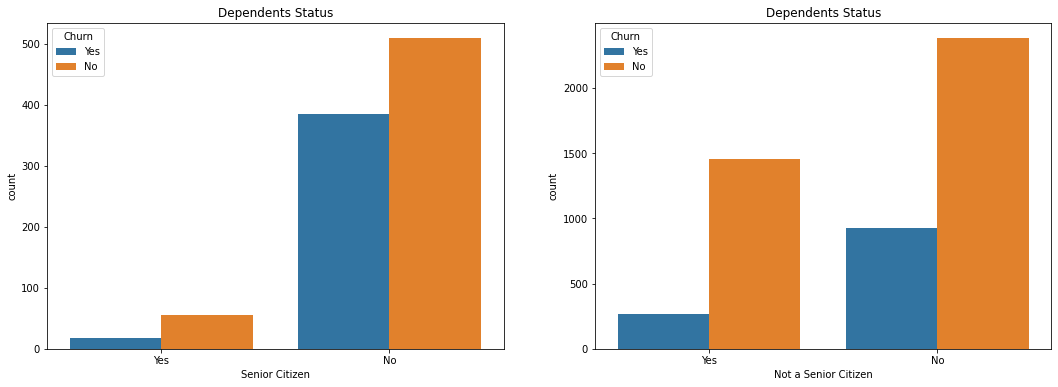

In [17]:
# Drill Down para melhor averiguar aposentados
df_aposentado = df.filter(df.SeniorCitizen == 1).groupBy('Churn', 'Dependents').count().orderBy(df.Churn.desc()).toPandas()
df_nao_aposentado = df.filter(df.SeniorCitizen == 0).groupBy('Churn', 'Dependents').count().orderBy(df.Churn.desc()).toPandas()
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.barplot(data = df_aposentado, x = 'Dependents', y = 'count', hue = 'Churn')
plt.xlabel('Senior Citizen')
plt.title('Dependents Status')
plt.subplot(1,2,2)
sns.barplot(data = df_nao_aposentado, x = 'Dependents', y = 'count', hue = 'Churn')
plt.xlabel('Not a Senior Citizen')
plt.title('Dependents Status')

<AxesSubplot:xlabel='SeniorCitizen', ylabel='tenure'>

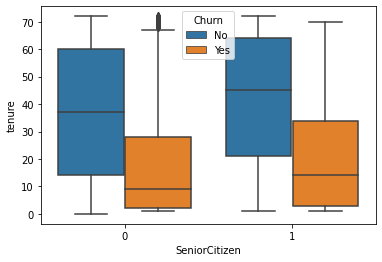

In [18]:
# Análise da dispersão da quantidade de meses que um cliente aposentado ou não permanece
df_box = df.select('SeniorCitizen', 'Churn', 'tenure').toPandas()
sns.boxplot(y = 'tenure', x = 'SeniorCitizen', data = df_box, hue = 'Churn')

### Para aqueles que cancelam e não são aposentados, as recargas mensais são maiores. Já entre os aposentados, não existe uma distinção significativa.

<AxesSubplot:xlabel='SeniorCitizen', ylabel='MonthlyCharges'>

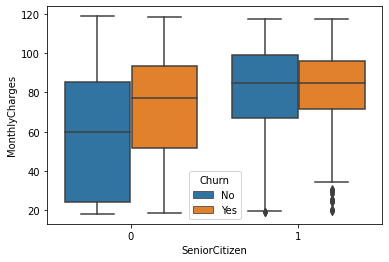

In [19]:
# Analisando dispersão das cargas mensais
df_box_charges = df.select('SeniorCitizen', 'Churn', 'MonthlyCharges').toPandas()
sns.boxplot(y = 'MonthlyCharges', x = 'SeniorCitizen', data = df_box_charges, hue = 'Churn')

### Clientes com total de cargas altas tendem a permanecer com o produto (aposentados ou não).

<AxesSubplot:xlabel='SeniorCitizen', ylabel='TotalCharges'>

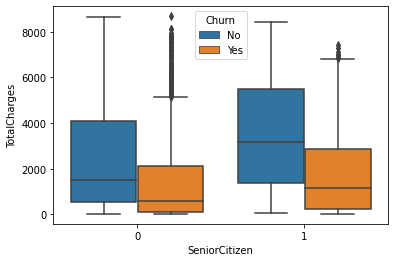

In [20]:
# Analisando dispersão de total de cargas mensais
df_box_total_charges = df.select('SeniorCitizen', 'Churn', 'TotalCharges').toPandas()
sns.boxplot(y = 'TotalCharges', x = 'SeniorCitizen', data = df_box_total_charges, hue = 'Churn')

## Pré-Processamento

In [21]:
# Cehcando Valores nulos
df.select(*(F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns)).show(vertical = True)

-RECORD 0---------------
 ID               | 0   
 customerID       | 0   
 gender           | 0   
 SeniorCitizen    | 0   
 Partner          | 0   
 Dependents       | 0   
 tenure           | 0   
 PhoneService     | 0   
 MultipleLines    | 0   
 InternetService  | 0   
 OnlineSecurity   | 0   
 OnlineBackup     | 0   
 DeviceProtection | 0   
 TechSupport      | 0   
 StreamingTV      | 0   
 StreamingMovies  | 0   
 Contract         | 0   
 PaperlessBilling | 0   
 PaymentMethod    | 0   
 MonthlyCharges   | 0   
 TotalCharges     | 10  
 Churn            | 0   



In [22]:
# Chamando método para remover outliers
imputer = Imputer(inputCol="TotalCharges", outputCol="TotalCharges_na").setStrategy("mean")
df = imputer.fit(df).transform(df)

### De acordo com a matrix de correlação, podemos excluir a variável TotalCharges para evitar problemas com multicolinearidade

In [23]:
# Avaliando correlação
columns = [i for i in df.columns if df.select(i).dtypes[0][1] != 'string' and i != 'ID' and i != 'TotalCharges']
vetor = "corr_features"
vct_assembler = VectorAssembler(inputCols=columns, outputCol=vetor)
df_vetor = vct_assembler.transform(df.select(columns)).select(vetor)
matrix = Correlation.corr(df_vetor, 'corr_features', method = 'pearson')
result = matrix.collect()[0]["pearson({})".format(vetor)].values
pd.DataFrame(result.reshape(-1, len(columns)), columns=columns, index=columns)


,tenure,MonthlyCharges,TotalCharges_na
tenure,1.000000,0.256983,0.826223
MonthlyCharges,0.256983,1.000000,0.655830
TotalCharges_na,0.826223,0.655830,1.000000


In [24]:
df = df.drop('TotalCharges', 'TotalCharges_na', 'ID', 'customerID')

In [25]:
df.show(vertical = True)

-RECORD 0--------------------------------
 gender           | Male                 
 SeniorCitizen    | 0                    
 Partner          | Yes                  
 Dependents       | Yes                  
 tenure           | 72                   
 PhoneService     | Yes                  
 MultipleLines    | Yes                  
 InternetService  | No                   
 OnlineSecurity   | No internet service  
 OnlineBackup     | No internet service  
 DeviceProtection | No internet service  
 TechSupport      | No internet service  
 StreamingTV      | No internet service  
 StreamingMovies  | No internet service  
 Contract         | Two year             
 PaperlessBilling | No                   
 PaymentMethod    | Credit card (auto... 
 MonthlyCharges   | 24.1                 
 Churn            | No                   
-RECORD 1--------------------------------
 gender           | Female               
 SeniorCitizen    | 0                    
 Partner          | No            

In [26]:
# Chamando método para transformar variáveis categóricas em numéricas
indexers = [StringIndexer(inputCol=i, outputCol=i+"_index").fit(df) for i in df.columns if df.select(i).dtypes[0][1] == 'string']

In [27]:
# Chamando método para colocar variáveis em um vetor
featureIndexer = VectorAssembler(inputCols = [i + "_index" for i in df.columns if i != 'Churn' if i != 'Churn_index' if i != 'tenure' if i != 'MonthlyCharges'] + ['tenure', 'MonthlyCharges'], outputCol="features")

In [28]:
# Separando base em treino e teste
(trainingData, testData) = df.randomSplit([0.7, 0.3])


In [29]:
# Chamando modelo
gbt = GBTClassifier(labelCol="Churn_index", featuresCol="features")

In [30]:
# Criando pipeline
stages = indexers
stages.append(featureIndexer)
stages.append(gbt)
pipeline = Pipeline().setStages(stages)

## Treinando modelo

In [32]:
# Treinando modelo
model = pipeline.fit(trainingData).transform(testData)

## Avaliação do modelo

In [31]:
# Avaliando acurácia, precisão, revocação e medida F
def evaluate_model(model):
    metricas = ['accuracy', 'weightedPrecision', 'weightedRecall', 'weightedFMeasure']
    resultados = dict()

    for eval in metricas:
        evaluator = MulticlassClassificationEvaluator(
            labelCol="Churn_index", predictionCol="prediction", metricName=eval
            )
        resultados[eval] = evaluator.evaluate(model)

    for metric in resultados:
        print(f'{metric}: {resultados[metric]}')
    
    roc(model)

def roc(model):
    # Avaliando curva ROC
    roc_evaluator = BinaryClassificationEvaluator(labelCol='Churn_index')
    auroc = roc_evaluator.evaluate(model, {roc_evaluator.metricName: "areaUnderROC"})
    auprc = roc_evaluator.evaluate(model, {roc_evaluator.metricName: "areaUnderPR"})
    print("Area abaixo da curva ROC: {:.4f}".format(auroc))
    print("Area abaixo da curva PR: {:.4f}".format(auprc))

In [33]:
evaluate_model(model)

accuracy: 0.8004291845493562
weightedPrecision: 0.7933521984658716
weightedRecall: 0.8004291845493562
weightedFMeasure: 0.7957951968256071
Area abaixo da curva ROC: 0.8447
Area abaixo da curva PR: 0.6669


## Buscando melhores parâmetros

In [34]:
# Criando busca com variação entre os parametros abaixo
params = ParamGridBuilder() \
         .addGrid(gbt.maxDepth, [2, 8]) \
         .addGrid(gbt.maxIter,[10, 200]) \
         .build() 

In [35]:
# Criando um validação cruzada utilizando todo pipeline criado e com as variações citadas acima. Além disso, utilização de 5-folds
crossval = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=params,
                           evaluator=BinaryClassificationEvaluator(labelCol='Churn_index'),
                           numFolds=5)

In [36]:
cvModel = crossval.fit(trainingData).transform(testData)

In [37]:
evaluate_model(cvModel)

accuracy: 0.8063304721030042
weightedPrecision: 0.7969157563357716
weightedRecall: 0.8063304721030042
weightedFMeasure: 0.7987467505684397
Area abaixo da curva ROC: 0.8537
Area abaixo da curva PR: 0.6745
